## <center>Universidade do Estado do Amazonas</center>
##### <center>Pós-graduação Lato Sensu em Ciência de Dados</center>

<center>

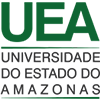

</center>

---

## <center>Código fonte do TCC: Análise dos dados 1º Trimestre de 2021</center>
##### <center>**Orientadora:** Msc. Alice Adativa</center>
###### <center>**Aluno:** Daniel Erasmo Leite Soares</center>



---



## <center>Fonte de dados.</center>

[DB Queimadas do INPE.](https://queimadas.dgi.inpe.br/queimadas/bdqueimadas)


## **Preparação do Ambiente**

---



In [1]:
# Pacotes instalados
!pip install geopandas
!pip install contextily
!pip install biokit
!pip install plotly

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 42.2 MB/s 
     |████████████████████████████████| 16.7 MB 385 kB/s 
     |████████████████████████████████| 19.3 MB 11.6 MB/s 
     |████████████████████████████████| 162 kB 5.1 MB/s 
     |████████████████████████████████| 47 kB 3.9 MB/s 
     |████████████████████████████████| 1.0 MB 48.5 MB/s 
     |████████████████████████████████| 2.3 MB 39.8 MB/s 
     |████████████████████████████████| 51 kB 195 kB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 64.9 MB/s 
     |████████████████████████████████| 5.8 MB 25.4 MB/s 
     |████████████████████████████████| 251 kB 68.3 MB/s 
     |████████████████████████████████| 127 kB 67.1 MB/s 
  Created wheel for biokit: filename=biokit-0.5.0-py3-none-any.whl size=177148 sha256=bed8033e7f81e871ea0943b553c256eed66c0f745a13a3df7f6dbf238d59c805
  Stored in directory: /root/.cache/pip/whee

In [2]:
## Bibliotecas de Tratamento de Dados
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import contextily
import numpy as np

## Bibliotecas Gráficas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go

## Bibliotecas de ML
from sklearn.cluster import KMeans

## **Carregamento e preparação do DataFrame de todos os Biomas**

---



In [3]:
# Montando a pasta do Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Criando os DataFrames de alertas de focos de queimadas do Brasil
alertas = pd.read_csv('/content/drive/MyDrive/TCC/dataset/meses_focos_biomas_2021-01-01_2021-12-31.csv')

## **Preparação do DataFrame somente do Bioma Amazônia**

---



In [5]:
alertas_amazonia = alertas[alertas['bioma'] == 'Amazonia']

## **Preparação do DataFrame com dados do 1º trimestre 2021**

---



In [6]:
alertas_m01 = alertas_amazonia[alertas_amazonia['mes'] == 1]
alertas_m02 = alertas_amazonia[alertas_amazonia['mes'] == 2]
alertas_m03 = alertas_amazonia[alertas_amazonia['mes'] == 3]

alertas_todos = [alertas_m01, alertas_m02, alertas_m03]
alertas_trim01 = pd.concat(alertas_todos)

In [7]:
alertas_trim01

,mes,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
97478,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,GAUCHA DO NORTE,Amazonia,NaN,NaN,NaN,-13.342,-53.703,22.0
97480,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,ITANHANGA,Amazonia,NaN,NaN,NaN,-12.347,-56.802,23.1
97481,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,SANTA CRUZ DO XINGU,Amazonia,NaN,NaN,NaN,-10.204,-52.331,16.4
97482,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,BRASNORTE,Amazonia,NaN,NaN,NaN,-13.011,-57.330,20.3
97483,1,2021/01/01 17:05:00,AQUA_M-T,Brasil,PARA,ITAITUBA,Amazonia,NaN,NaN,NaN,-3.902,-56.032,13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104225,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,TOCANTINS,ARAGUATINS,Amazonia,0.0,4.8,0.0,-5.845,-48.234,7.6
104228,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,PARA,SAO FELIX DO XINGU,Amazonia,3.0,5.4,0.0,-5.671,-51.617,11.0
104229,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,MATO GROSSO,GAUCHA DO NORTE,Amazonia,5.0,0.2,0.1,-13.087,-53.455,22.5
104231,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,MATO GROSSO,SANTA CARMEM,Amazonia,0.0,3.3,0.0,-12.086,-55.301,26.5


## **Criação o GeoDataFrame e Sistema de Referência de Coordenadas**

---



In [8]:
geometry = [Point(xy) for xy in zip(alertas_trim01['longitude'], alertas_trim01['latitude'])]

In [9]:
alertas_trim01 = gpd.GeoDataFrame(alertas_trim01, crs='EPSG:4326', geometry=geometry)

In [10]:
type(alertas_trim01)

geopandas.geodataframe.GeoDataFrame

In [11]:
alertas_trim01

,mes,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry
97478,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,GAUCHA DO NORTE,Amazonia,NaN,NaN,NaN,-13.342,-53.703,22.0,POINT (-53.70300 -13.34200)
97480,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,ITANHANGA,Amazonia,NaN,NaN,NaN,-12.347,-56.802,23.1,POINT (-56.80200 -12.34700)
97481,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,SANTA CRUZ DO XINGU,Amazonia,NaN,NaN,NaN,-10.204,-52.331,16.4,POINT (-52.33100 -10.20400)
97482,1,2021/01/01 17:00:00,AQUA_M-T,Brasil,MATO GROSSO,BRASNORTE,Amazonia,NaN,NaN,NaN,-13.011,-57.330,20.3,POINT (-57.33000 -13.01100)
97483,1,2021/01/01 17:05:00,AQUA_M-T,Brasil,PARA,ITAITUBA,Amazonia,NaN,NaN,NaN,-3.902,-56.032,13.1,POINT (-56.03200 -3.90200)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104225,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,TOCANTINS,ARAGUATINS,Amazonia,0.0,4.8,0.0,-5.845,-48.234,7.6,POINT (-48.23400 -5.84500)
104228,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,PARA,SAO FELIX DO XINGU,Amazonia,3.0,5.4,0.0,-5.671,-51.617,11.0,POINT (-51.61700 -5.67100)
104229,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,MATO GROSSO,GAUCHA DO NORTE,Amazonia,5.0,0.2,0.1,-13.087,-53.455,22.5,POINT (-53.45500 -13.08700)
104231,3,2021/03/31 16:55:00,AQUA_M-T,Brasil,MATO GROSSO,SANTA CARMEM,Amazonia,0.0,3.3,0.0,-12.086,-55.301,26.5,POINT (-55.30100 -12.08600)


In [12]:
alertas_trim01 = alertas_trim01.to_crs(crs='EPSG:3857')

In [13]:
alertas_trim01.crs.to_string()

'EPSG:3857'

## **Geração dos gráficos de quantitativos e localização dos focos por Estado**

In [14]:
alertas_trim01['estado'].unique()

array(['MATO GROSSO', 'PARA', 'AMAZONAS', 'MARANHAO', 'RONDONIA',
       'RORAIMA', 'TOCANTINS', 'ACRE', 'AMAPA'], dtype=object)

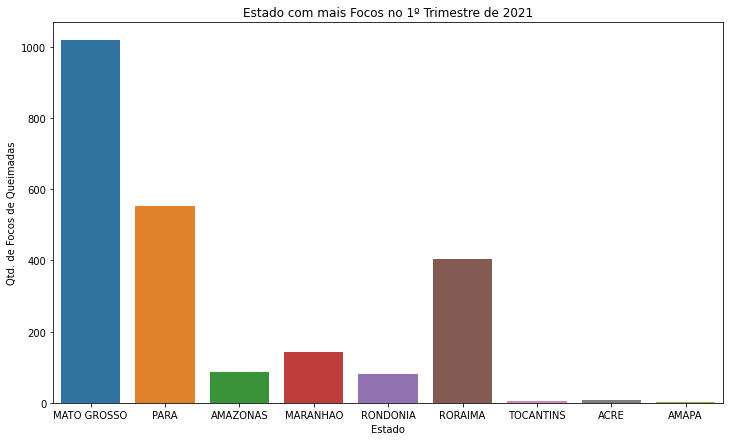

In [15]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x='estado', data=alertas_trim01)
ax.set_title("Estado com mais Focos no 1º Trimestre de 2021")
ax.set_xlabel('Estado')
ax.set_ylabel('Qtd. de Focos de Queimadas')
plt.show()

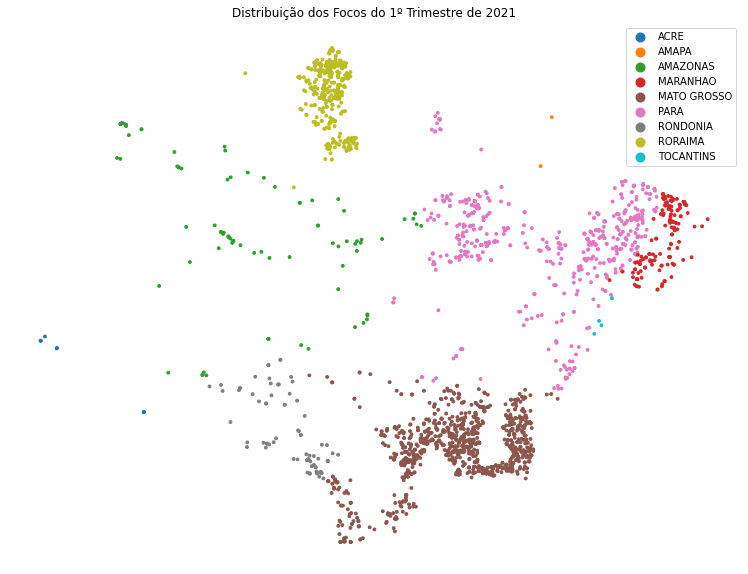

In [25]:
ax = alertas_trim01.plot(figsize=(15, 10), column='estado', markersize=8, legend=True)
#contextily.add_basemap(ax)
ax.set_axis_off()
ax.set_title("Distribuição dos Focos do 1º Trimestre de 2021")
plt.show()

## **Aplicação dos Algoritmo K-Means**

**K-Means Para o Bioma Amazônia**

In [17]:
coord_amazonia = alertas_trim01.drop(columns=["datahora","satelite","pais","estado","municipio","bioma","diasemchuva","precipitacao","riscofogo","frp","geometry"])

In [18]:
coord_amazonia

,mes,latitude,longitude
97478,1,-13.342,-53.703
97480,1,-12.347,-56.802
97481,1,-10.204,-52.331
97482,1,-13.011,-57.330
97483,1,-3.902,-56.032
...,...,...,...
104225,3,-5.845,-48.234
104228,3,-5.671,-51.617
104229,3,-13.087,-53.455
104231,3,-12.086,-55.301


In [19]:
agrupadorK = KMeans(n_clusters=9)

In [20]:
agrupadorK.fit(coord_amazonia)

KMeans(n_clusters=9)

In [21]:
np.unique(agrupadorK.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [22]:
coord_amazonia['Grupo'] = agrupadorK.labels_

In [23]:
coord_amazonia

,mes,latitude,longitude,Grupo
97478,1,-13.342,-53.703,7
97480,1,-12.347,-56.802,3
97481,1,-10.204,-52.331,7
97482,1,-13.011,-57.330,3
97483,1,-3.902,-56.032,6
...,...,...,...,...
104225,3,-5.845,-48.234,1
104228,3,-5.671,-51.617,1
104229,3,-13.087,-53.455,7
104231,3,-12.086,-55.301,3


**Gráfico com agrupamento por Cluster**

In [24]:
from seaborn.utils import locator_to_legend_entries
c0lat = coord_amazonia[coord_amazonia['Grupo']==0]['latitude']
c0lon = coord_amazonia[coord_amazonia['Grupo']==0]['longitude']
c1lat = coord_amazonia[coord_amazonia['Grupo']==1]['latitude']
c1lon = coord_amazonia[coord_amazonia['Grupo']==1]['longitude']
c2lat = coord_amazonia[coord_amazonia['Grupo']==2]['latitude']
c2lon = coord_amazonia[coord_amazonia['Grupo']==2]['longitude']
c3lat = coord_amazonia[coord_amazonia['Grupo']==3]['latitude']
c3lon = coord_amazonia[coord_amazonia['Grupo']==3]['longitude']
c4lat = coord_amazonia[coord_amazonia['Grupo']==4]['latitude']
c4lon = coord_amazonia[coord_amazonia['Grupo']==4]['longitude']
c5lat = coord_amazonia[coord_amazonia['Grupo']==5]['latitude']
c5lon = coord_amazonia[coord_amazonia['Grupo']==5]['longitude']
c6lat = coord_amazonia[coord_amazonia['Grupo']==6]['latitude']
c6lon = coord_amazonia[coord_amazonia['Grupo']==6]['longitude']
c7lat = coord_amazonia[coord_amazonia['Grupo']==7]['latitude']
c7lon = coord_amazonia[coord_amazonia['Grupo']==7]['longitude']
c8lat = coord_amazonia[coord_amazonia['Grupo']==8]['latitude']
c8lon = coord_amazonia[coord_amazonia['Grupo']==8]['longitude']

x0 = c0lat 
y0 = c0lon
x1 = c1lat
y1 = c1lon
x2 = c2lat
y2 = c2lon
x3 = c3lat
y3 = c3lon
x4 = c4lat
y4 = c4lon
x5 = c5lat
y5 = c5lon
x6 = c6lat
y6 = c6lon
x7 = c7lat
y7 = c7lon
x8 = c8lat
y8 = c8lon

# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(
    go.Scatter(
        x=x0,
        y=y0,
        mode="markers",
        marker=dict(color="paleturquoise")
    )
)

fig.add_trace(
    go.Scatter(
        x=x1,
        y=y1,
        mode="markers",
        marker=dict(color="limegreen")
    )
)

fig.add_trace(
    go.Scatter(
        x=x2,
        y=y2,
        mode="markers",
        marker=dict(color="tomato")
    )
)

fig.add_trace(
    go.Scatter(
        x=x3,
        y=y3,
        mode="markers",
        marker=dict(color="dodgerblue")
    )
)

fig.add_trace(
    go.Scatter(
        x=x4,
        y=y4,
        mode="markers",
        marker=dict(color="rebeccapurple")
    )
)

fig.add_trace(
    go.Scatter(
        x=x5,
        y=y5,
        mode="markers",
        marker=dict(color="yellow")
    )
)

fig.add_trace(
    go.Scatter(
        x=x6,
        y=y6,
        mode="markers",
        marker=dict(color="chartreuse")
    )
)

fig.add_trace(
    go.Scatter(
        x=x7,
        y=y7,
        mode="markers",
        marker=dict(color="chocolate")
    )
)

fig.add_trace(
    go.Scatter(
        x=x8,
        y=y8,
        mode="markers",
        marker=dict(color="red")
    )
)


# Add buttons that add shapes
cluster0 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x0), y0=min(y0),
                            x1=max(x0), y1=max(y0),
                            line=dict(color="paleturquoise"))]
cluster1 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x1), y0=min(y1),
                            x1=max(x1), y1=max(y1),
                            line=dict(color="limegreen"))]
cluster2 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x2), y0=min(y2),
                            x1=max(x2), y1=max(y2),
                            line=dict(color="tomato"))]
cluster3 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x3), y0=min(y3),
                            x1=max(x3), y1=max(y3),
                            line=dict(color="dodgerblue"))]
cluster4 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x4), y0=min(y4),
                            x1=max(x4), y1=max(y4),
                            line=dict(color="rebeccapurple"))]
cluster5 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x5), y0=min(y5),
                            x1=max(x5), y1=max(y5),
                            line=dict(color="yellow"))]
cluster6 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x6), y0=min(y6),
                            x1=max(x6), y1=max(y6),
                            line=dict(color="chartreuse"))]
cluster7 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x7), y0=min(y7),
                            x1=max(x7), y1=max(y7),
                            line=dict(color="chocolate"))]
cluster8 = [dict(type="circle",
                            xref="x", yref="y",
                            x0=min(x8), y0=min(y8),
                            x1=max(x8), y1=max(y8),
                            line=dict(color="red"))]
fig.update_layout(
    updatemenus=[
        dict(buttons=list([
            dict(label="None",
                 method="relayout",
                 args=["shapes", []]),
            dict(label="Cluster 0",
                 method="relayout",
                 args=["shapes", cluster0]),
            dict(label="Cluster 1",
                 method="relayout",
                 args=["shapes", cluster1]),
            dict(label="Cluster 2",
                 method="relayout",
                 args=["shapes", cluster2]),
            dict(label="Cluster 3",
                 method="relayout",
                 args=["shapes", cluster3]),
            dict(label="Cluster 4",
                 method="relayout",
                 args=["shapes", cluster4]),
            dict(label="Cluster 5",
                 method="relayout",
                 args=["shapes", cluster5]),
            dict(label="Cluster 6",
                 method="relayout",
                 args=["shapes", cluster6]),
            dict(label="Cluster 7",
                 method="relayout",
                 args=["shapes", cluster7]),
            dict(label="Cluster 8",
                 method="relayout",
                 args=["shapes", cluster8]),
            dict(label="All",
                 method="relayout",
                 args=["shapes", cluster0 + cluster1 + cluster2 + cluster3 + cluster4 + cluster5 + cluster6 + cluster7 + cluster8])
        ]),
        )
    ]
)

# Update remaining layout properties
fig.update_layout(
     title_text="Clusters do 1º Trimestre de 2021",
    showlegend=False,
)
fig.show()
